<a href="https://colab.research.google.com/github/Ambg0231/DeepLearning/blob/main/%5BTALLER%5D_CNN_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller: CNN Architectures

**Nombres: Ángela Burgos, Sandra Escobar**

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-DEEP-LEARNING-1/main/init.py
import init; init.init(force_download=False);

replicating local resources


In [ ]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

## Check the following article on network architectures

- https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

In particular,

- GlobalAveragePooling
- 1x1 convolutions
- Skip connections
- Networks modules:
    - **Inception**: multiple filter sizes on the same level (see [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202))
    - **Resnet**: learns residuals, gradients back propagate larger to earlier layers (see [here](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec))
    - **Xception**: depthwise separable convolutions (see [here](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec))
    

# Task: Use a Tensorflow hub model for image feature vector extraction

- browse this page, https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector
- select a TF2.0 model that provides feature vector
- load and resize the mini-cifar2 dataset to the image size required by the selected model (see [`skimage.transform.resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html?ref=driverlayer.com/web#skimage.transform.resize))
- apply the selected model layer to the resized mini-cifar2 dataset
- use any classical method from `scikit-learn` to create a classifier

In [ ]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2024-08-31 20:42:34--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.217.123, 16.182.68.248, 52.216.45.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.217.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9.5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9.48M  3.16MB/s    in 3.0s    

2024-08-31 20:42:37 (3.16 MB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



(0.0, 1.0)

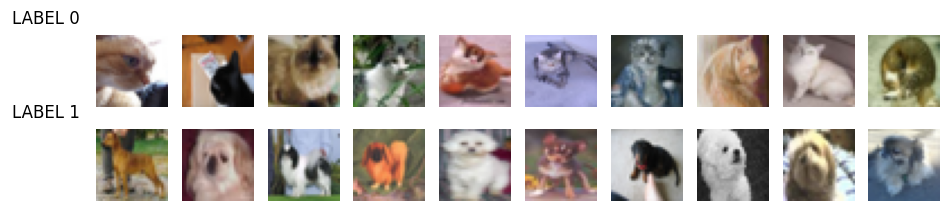

In [ ]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]

x_cifar = x_cifar[y_cifar!=2]
y_cifar = y_cifar[y_cifar!=2]
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
1    402
0    398
Name: count, dtype: int64

distribution of test classes
0    105
1     95
Name: count, dtype: int64


## Observe how we can apply a model to input data

- this example shows an untrained model
- you will have to do similarly with tfhub models

In [ ]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.InputLayer((32,32,3)))
m.add(tf.keras.layers.Flatten())
m.add(tf.keras.layers.Dense(20, activation="sigmoid"))


In [ ]:
output = m(x_train.astype(np.float32)).numpy()
output.shape

(800, 20)

In [ ]:
output

array([[0.49043232, 0.39522818, 0.44670433, ..., 0.4623968 , 0.58521694,
        0.48469362],
       [0.38426113, 0.49893785, 0.44665802, ..., 0.36126298, 0.66704714,
        0.62801164],
       [0.3987191 , 0.43000072, 0.4649733 , ..., 0.42231742, 0.6844824 ,
        0.6323612 ],
       ...,
       [0.5011146 , 0.44529623, 0.58808804, ..., 0.41454494, 0.634045  ,
        0.5406112 ],
       [0.4429081 , 0.4242601 , 0.4278316 , ..., 0.3226185 , 0.64799833,
        0.61244607],
       [0.47149128, 0.41937605, 0.39889982, ..., 0.43778256, 0.5689063 ,
        0.5747827 ]], dtype=float32)

## Your solution here

In [ ]:
import tensorflow_hub as hub
from skimage.transform import resize

In [ ]:
#mobilenet_v2
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
model = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)

In [ ]:
x_train_resized = np.array([resize(image, (224, 224)) for image in x_train])
x_test_resized = np.array([resize(image, (224, 224)) for image in x_test])

In [ ]:
x_train_features = model(x_train_resized).numpy()
x_test_features = model(x_test_resized).numpy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
clf.fit(x_train_features, y_train)
y_pred = clf.predict(x_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")

Exactitud del modelo: 81.50%


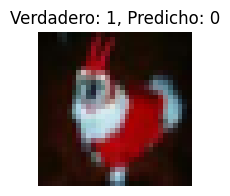

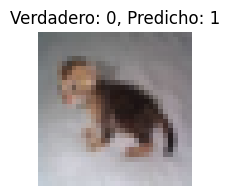

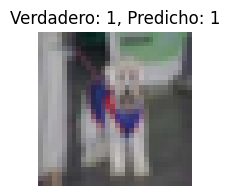

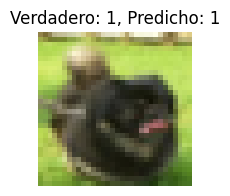

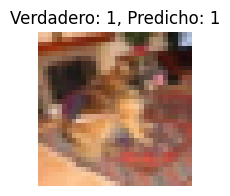

In [ ]:
import matplotlib.pyplot as plt

indices = np.random.choice(len(x_test), 5)
images = x_test[indices]
true_labels = y_test[indices]
pred_labels = clf.predict(x_test_features[indices])

for i, (image, true_label, pred_label) in enumerate(zip(images, true_labels, pred_labels)):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.title(f"Verdadero: {true_label}, Predicho: {pred_label}")
    plt.axis('off')
    plt.show()